In [29]:
!wget https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip

--2024-07-16 06:32:29--  https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::22c5:2ef4, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105946856 (101M) [application/zip]
Saving to: ‘fruits.zip.2’

fruits.zip.2        100%[===================>] 101.04M  53.8MB/s    in 1.9s    

2024-07-16 06:32:33 (53.8 MB/s) - ‘fruits.zip.2’ saved [105946856/105946856]



In [19]:
!unzip fruits.zip

Archive:  fruits.zip
replace __MACOSX/._fruits? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [22]:
img_height, img_width = 32, 32
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/validation",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 460 files belonging to 3 classes.
Found 66 files belonging to 3 classes.
Found 130 files belonging to 3 classes.


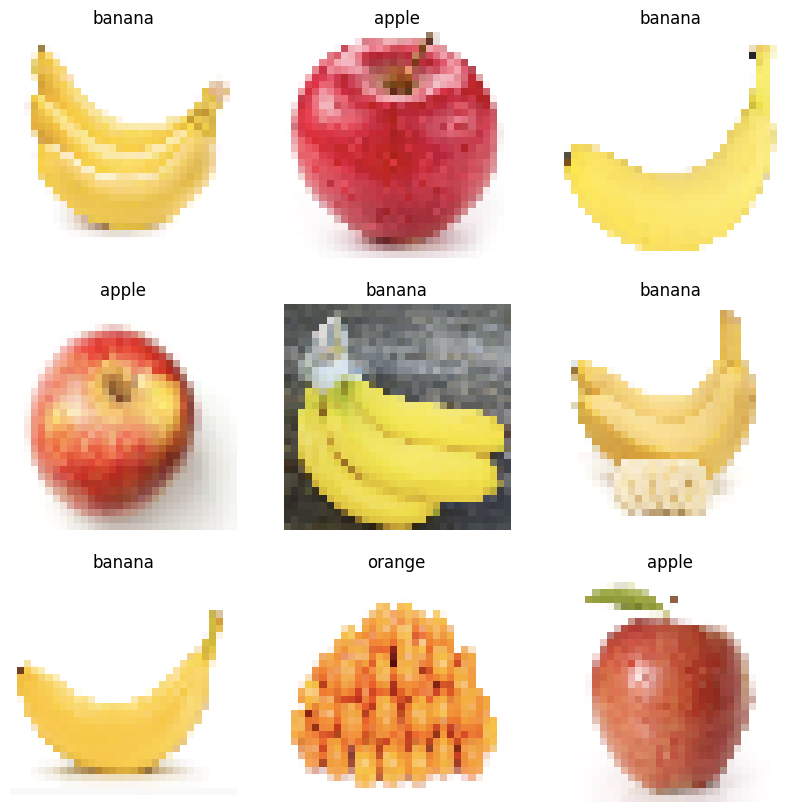

In [23]:
class_names = ["apple", "banana", "orange"]
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(3)
    ]
)

In [25]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy']
)

In [26]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 15
)

Epoch 1/15
23/23 [==============================] - 4s 78ms/step - loss: 0.9668 - accuracy: 0.5739 - val_loss: 0.7377 - val_accuracy: 0.5758
Epoch 2/15
23/23 [==============================] - 3s 118ms/step - loss: 0.5955 - accuracy: 0.7543 - val_loss: 0.7137 - val_accuracy: 0.6515
Epoch 3/15
23/23 [==============================] - 2s 69ms/step - loss: 0.3979 - accuracy: 0.8500 - val_loss: 0.4861 - val_accuracy: 0.7879
Epoch 4/15
23/23 [==============================] - 2s 68ms/step - loss: 0.2854 - accuracy: 0.8848 - val_loss: 0.5054 - val_accuracy: 0.7273
Epoch 5/15
23/23 [==============================] - 2s 69ms/step - loss: 0.2282 - accuracy: 0.9152 - val_loss: 0.2247 - val_accuracy: 0.9091
Epoch 6/15
23/23 [==============================] - 2s 69ms/step - loss: 0.1993 - accuracy: 0.9283 - val_loss: 0.3646 - val_accuracy: 0.8636
Epoch 7/15
23/23 [==============================] - 4s 129ms/step - loss: 0.1591 - accuracy: 0.9587 - val_loss: 0.1615 - val_accuracy: 0.9394
Epoch 8/15


In [27]:
model.evaluate(test_ds)

7/7 [==============================] - 0s 6ms/step - loss: 0.1653 - accuracy: 0.9385


[0.16527962684631348, 0.9384615421295166]

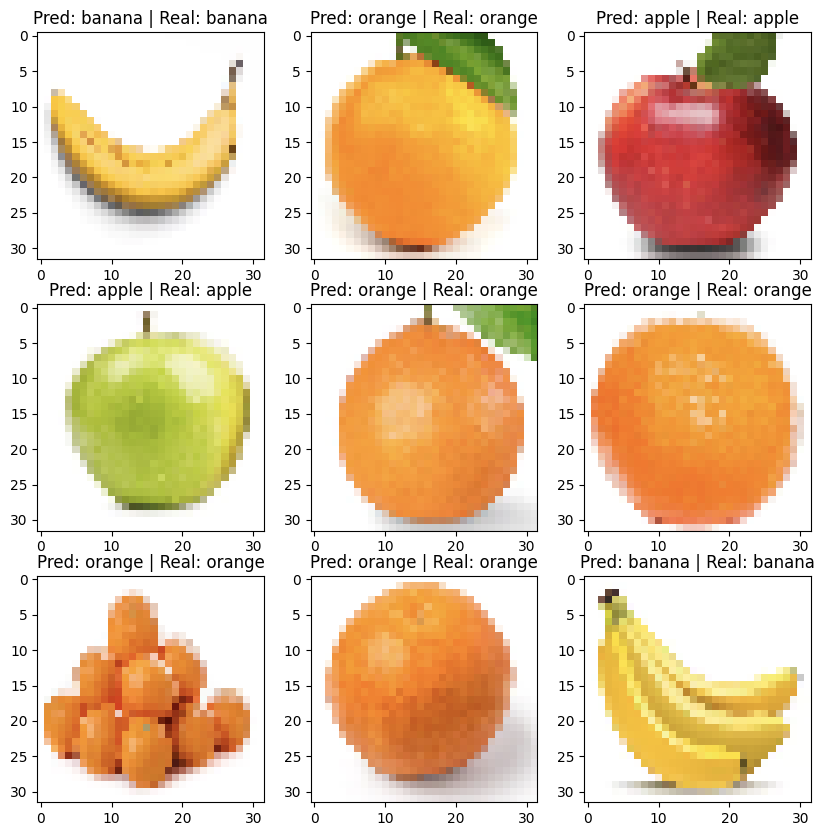

In [31]:
import numpy

plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  # print(classifications)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)